### *Install Requirements* ###

In [1]:
pip install -r ../config/requirements.txt

Note: you may need to restart the kernel to use updated packages.


### *Import Libraries* ###

In [2]:
from sqlalchemy import Column, Integer, String, Boolean, Date, CHAR
from sqlalchemy.orm import declarative_base
from sqlalchemy import create_engine, select, func
from sqlalchemy.orm import sessionmaker
import json
import pandas as pd
from sqlalchemy import func, extract
import matplotlib.pyplot as plt
import numpy as np
import sys
import datetime

sys.path.append('../')
from db_model.models_structure import BestCandidates
from db_model.models_structure import Candidates


### *Connection to DB* ###

In [3]:
with open('../config/credentials.json', 'r') as json_file:
    data = json.load(json_file)
    host = data["host"]
    database = data["database"]
    user = data["user"]
    password = data["password"]

database_connection = f"mysql://{user}:{password}@{host}/{database}"
engine = create_engine(database_connection)

### *In this session, we load the data from the database and add the column "is_hire" with its respective criterion to calculate whether or not it is hired.* ###
### *Afterwards, Uploaded to a New Table* ###

In [4]:
Session = sessionmaker(bind=engine)
session = Session()

all_candidates = session.query(Candidates).all()

for candidate in all_candidates:

    is_hire = 1 if (int(candidate.code_challenge_score) >= 7 and int(candidate.technical_interview_score) >= 7) else 0

    applicant_date = datetime.datetime.strptime(candidate.applicant_date, "%Y-%m-%d")  

    best_candidate = BestCandidates(
        applicant_date=applicant_date,
        code_challenge_score=int(candidate.code_challenge_score),
        country=candidate.country,
        email=candidate.email,
        experience_year=int(candidate.experience_year),
        first_name=candidate.first_name,
        is_hire=is_hire,
        last_name=candidate.last_name,
        seniority=candidate.seniority,
        technical_interview_score=int(candidate.technical_interview_score),
        technology=candidate.technology,
    )
    session.add(best_candidate)

session.commit()
session.close()

### *Check new Table* ###

![Check Table](../notebooks/New%20Table.png)

# *EDA* #

### *First, we will see the percentage of candidates who were hired* ###






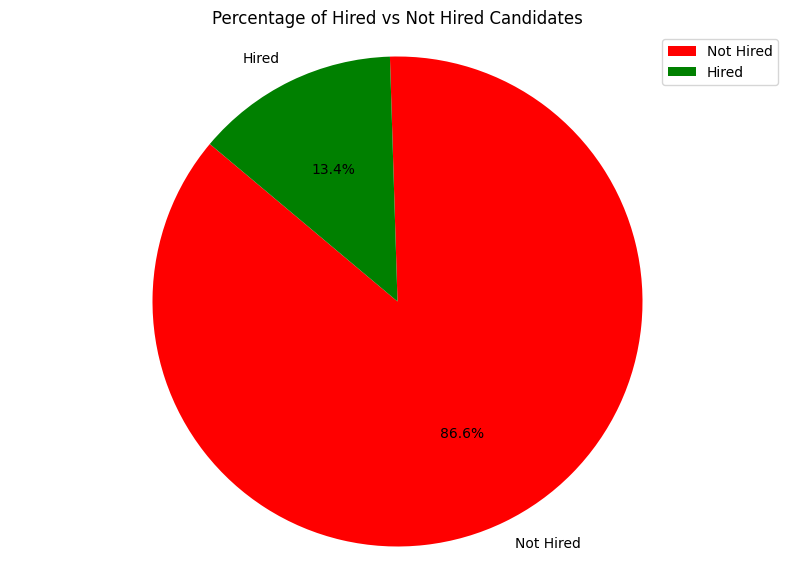

In [5]:
session = Session(bind=engine)

stmt = select(
    BestCandidates.is_hire,
    func.count(BestCandidates.id)
).group_by(BestCandidates.is_hire)

# Execute the query
results = session.execute(stmt).fetchall()

session.close()

labels = ['Not Hired', 'Hired']
values = [0, 0]  
for result in results:
    if result[0] == 0:  
        values[0] = result[1]
    elif result[0] == 1:
        values[1] = result[1]

fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=["red","green"])
ax.set_title('Percentage of Hired vs Not Hired Candidates')
plt.legend(labels, loc="best")
plt.axis('equal')

plt.show()

# *Queries* #

### *Before conducting the analysis, categorization is done to facilitate data management in the following way:* ###

***Development and Data Analysis:***

*- Includes all development categories (Backend, Frontend, FullStack, CMS Backend, CMS Frontend, Game Development) and those related to data (Business Intelligence, Data Engineer, Business Analytics/Project Management).*

*- Justification: These areas often overlap in terms of skills and tools. Grouping them into a single category reflects the focus on creating solutions and analyzing data.*

***IT Infrastructure & Operations:***

*- Includes Database Administration, System Administration, and DevOps.*

*- Justification: These areas focus on the support, deployment, and maintenance of technology infrastructure, which is fundamental for the operation of software systems.*

***Quality Assurance & Security:***

*- Combines QA Manual, QA Automation, and all subcategories of Security.*

*- Justification: Covers activities aimed at ensuring the quality and security of software, two crucial aspects in the development and maintenance of systems.*

***Customer Relationship Management & Success:***

*- Groups Client Success, Sales, Social Media Community Management, and Salesforce.*

*- Justification: These areas focus on customer interaction and relationship management to drive customer success and satisfaction.*

***Content Management & Design:***

*- Combines Technical Writing, Design, Adobe Experience Manager, and includes Mulesoft (though Mulesoft is specifically an integration platform, it could be considered here as part of a broader focus on managing and presenting digital content).*

*- Justification: This category focuses on the creation, management, and design of content, covering both technical and creative aspects.*

### *Here, a search is made to the database to extract information about the technologies and hires.* ###
### *Afterwards, they are saved in a dataframe to start grouping the data and performing the analytics.* ###

In [6]:
Session = sessionmaker(bind=engine)

with Session() as session:
    stmt = select(BestCandidates.technology, BestCandidates.is_hire) 
    results = session.execute(stmt).fetchall()

Session = sessionmaker(bind=engine)

data = []

with Session() as session:
    stmt = select(BestCandidates.technology, BestCandidates.is_hire) 
    results = session.execute(stmt).fetchall()
    for result in results:
        data.append(result)

df = pd.DataFrame(data, columns=['Technology', 'Is_Hired'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Technology  50000 non-null  object
 1   Is_Hired    50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


### *Grouping the data & Uploading to Data Base* ###

In [8]:
df = pd.read_sql_table('aspirant', con=engine)

#Dictionary to map technologies to categories
tech_to_category = {
    "Development - Backend": "Software Development",
    "Development - CMS Backend": "Software Development",
    "Development - CMS Frontend": "Software Development",
    "Development - Frontend": "Software Development",
    "Development - FullStack": "Software Development",
    "Game Development": "Software Development",
    "Business Intelligence": "Data & Analytics",
    "Data Engineer": "Data & Analytics",
    "Database Administration": "IT Infrastructure & Operations",
    "System Administration": "IT Infrastructure & Operations",
    "DevOps": "IT Infrastructure & Operations",
    "QA Manual": "Quality Assurance",
    "QA Automation": "Quality Assurance",
    "Security": "Security",
    "Security Compliance": "Security",
}

with Session() as session:
    aspirants = session.query(BestCandidates).all()
    for aspirant in aspirants:
        aspirant.technology_category = tech_to_category.get(aspirant.technology, "Other")
        session.add(aspirant)
    session.commit()

df['category'] = df['technology'].apply(lambda x: tech_to_category.get(x, "other"))
df = df.drop('technology_category', axis=1)


In [9]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         50000 non-null  int64         
 1   applicant_date             50000 non-null  datetime64[ns]
 2   code_challenge_score       50000 non-null  int64         
 3   country                    50000 non-null  object        
 4   email                      50000 non-null  object        
 5   experience_year            50000 non-null  int64         
 6   first_name                 50000 non-null  object        
 7   is_hire                    50000 non-null  int64         
 8   last_name                  50000 non-null  object        
 9   seniority                  50000 non-null  object        
 10  technical_interview_score  50000 non-null  int64         
 11  technology                 50000 non-null  object        
 12  cate

,id,applicant_date,code_challenge_score,country,email,experience_year,first_name,is_hire,last_name,seniority,technical_interview_score,technology,category
0,1,2021-02-26,3,Norway,leonard91@yahoo.com,2,Bernadette,0,Langworth,Intern,3,Data Engineer,Data & Analytics
1,2,2021-09-09,2,Panama,zelda56@hotmail.com,10,Camryn,0,Reynolds,Intern,10,Data Engineer,Data & Analytics
2,3,2020-04-14,10,Belarus,okey_schultz41@gmail.com,4,Larue,1,Spinka,Mid-Level,9,Client Success,other
3,4,2020-10-01,7,Eritrea,elvera_kulas@yahoo.com,25,Arch,0,Spinka,Trainee,1,QA Manual,Quality Assurance
4,5,2020-05-20,9,Myanmar,minnie.gislason@gmail.com,13,Larue,1,Altenwerth,Mid-Level,7,Social Media Community Management,other


### *1. Hires by Technology* ###

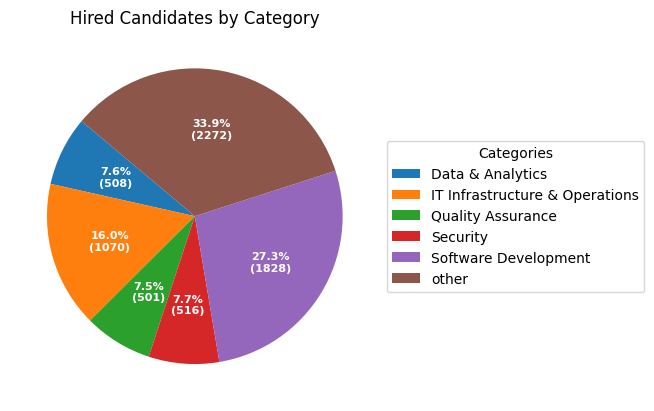

In [10]:

hired_by_category = df.groupby('category')['is_hire'].sum()

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(hired_by_category, autopct=lambda pct: func(pct, hired_by_category),
                                  textprops=dict(color="w"), startangle=140)

ax.legend(wedges, hired_by_category.index,
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Hired Candidates by Category")

plt.show()

*The category with the highest number of hires is Other, followed by Software Development. The other categories have lower percentages.*

### *Hires by year* ###

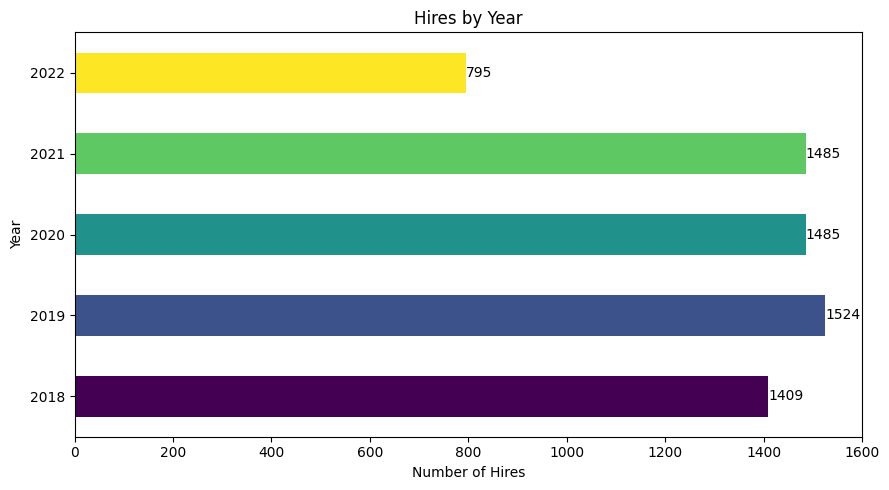

In [11]:
df['applicant_date'] = pd.to_datetime(df['applicant_date'])
df['year'] = df['applicant_date'].dt.year
hires_by_year = df[df['is_hire'] == 1].groupby('year').size()


colors = plt.cm.viridis(np.linspace(0, 1, len(hires_by_year)))
plt.figure(figsize=(9, 5))
ax = hires_by_year.plot(kind='barh', color=colors)
plt.xlabel('Number of Hires')
plt.ylabel('Year')
plt.title('Hires by Year')

for index, value in enumerate(hires_by_year):
    plt.text(value, index, str(value), va='center')

plt.tight_layout()
plt.show()

*2018: There were approximately 1409 hires.*

*2019: The number increased to about 1524 hires.*

*2020 and 2021: It remained constant at 1485 hires in both years.*

*2022: A drastic decrease to only 795 hires was observed.*

### *Hires by seniority* ###

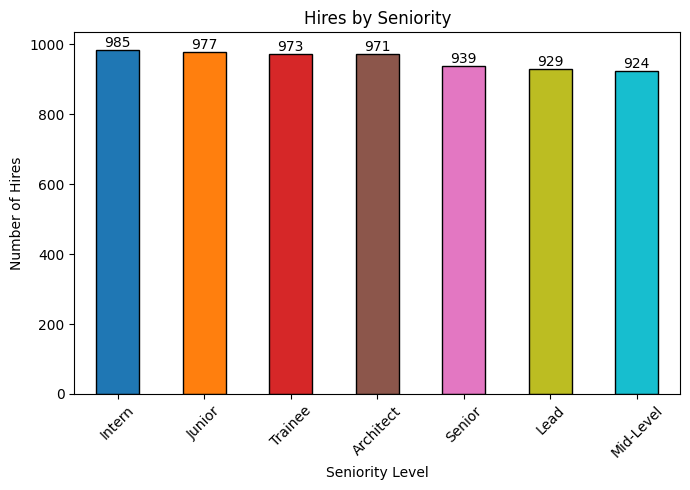

In [12]:
hired_df = df[df['is_hire'] == 1]
hires_by_seniority = hired_df.groupby('seniority').size().sort_values(ascending=False)

colors = plt.cm.tab10(np.linspace(0, 1, len(hires_by_seniority)))
plt.figure(figsize=(7, 5))

ax = hires_by_seniority.plot(kind='bar', color=colors, edgecolor='black')

plt.xlabel('Seniority Level')
plt.ylabel('Number of Hires')
plt.title('Hires by Seniority')

for i, value in enumerate(hires_by_seniority):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Interns have the highest number of hires, followed very closely by the junior, trainee, and architect levels. The senior, lead, and mid-level positions have fewer hires.*

### *Hires by Country Over Years* ###

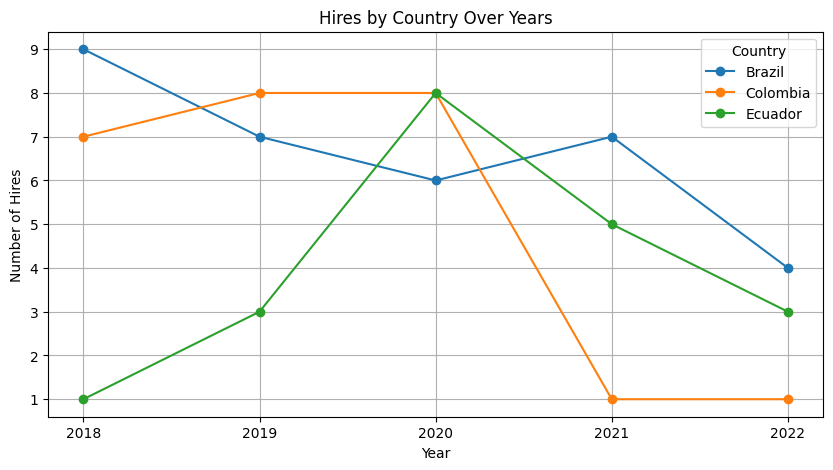

In [13]:
filtered_df = df[(df['is_hire'] == 1) & (df['country'].isin(['USA', 'Brazil', 'Colombia', 'Ecuador']))].copy()
filtered_df['year'] = pd.to_datetime(filtered_df['applicant_date']).dt.year

hires_by_country_year = filtered_df.groupby(['country', 'year']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 5))

for country in hires_by_country_year.index:
    plt.plot(hires_by_country_year.columns, hires_by_country_year.loc[country], marker='o', label=country)

plt.xticks(hires_by_country_year.columns, labels=hires_by_country_year.columns.astype(int))
plt.xlabel('Year')
plt.ylabel('Number of Hires')
plt.title('Hires by Country Over Years')
plt.legend(title='Country')
plt.grid(True)

plt.show()

*Brazil: Experienced a steady increase in hires until 2020, followed by a decrease.*

*Colombia: Reached a significant peak in 2020 and then decreased.*

*Ecuador: Has been steadily increasing year over year.*